<a href="https://colab.research.google.com/github/jAndrewtomich/2020-US-Elections/blob/main/2020_presidential_votes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
president_county_df = pd.read_csv('president_county.csv')

In [ ]:
president_state_df = pd.read_csv('president_state.csv')

In [3]:
president_county_candidate_df = pd.read_csv('president_county_candidate.csv')

In [4]:
president_county_candidate_df.loc[(president_county_candidate_df.candidate == ' Write-ins'), 'candidate'] = 'Write-ins'

# Index 49 in the above frame clearly shows that the total reported voter count for the 2020 US Presidential Election was ~152.7M people.  The population is ~330M.

In [5]:
#aggregate votes by state

state_votes_df = president_county_candidate_df.groupby(['state', 'candidate']).total_votes.sum()
state_votes_df = pd.DataFrame(state_votes_df).reset_index()

In [6]:
interests_df = state_votes_df[(state_votes_df.candidate == 'Joe Biden') | (state_votes_df.candidate == 'Donald Trump') | (state_votes_df.candidate == 'Jo Jorgensen') | 
                              (state_votes_df.candidate == 'Write-ins') | (state_votes_df.candidate == 'Kanye West')]

In [12]:
trump_df = interests_df[interests_df.candidate == 'Donald Trump'].reset_index()
trump_df = trump_df.drop('index', axis=1)
biden_df = interests_df[interests_df.candidate == 'Joe Biden'].reset_index()
biden_df = biden_df.drop('index', axis=1)
jorgensen_df = interests_df[interests_df.candidate == 'Jo Jorgensen'].reset_index()
jorgensen_df = jorgensen_df.drop('index', axis=1)
west_df = interests_df[interests_df.candidate == 'Kanye West'].reset_index()
west_df = west_df.drop('index', axis = 1)
writeins_df = interests_df[interests_df.candidate == 'Write-ins'].reset_index()
writeins_df = writeins_df.drop('index', axis = 1)

In [14]:
for s in list(trump_df.state):
  if s not in list(writeins_df.state):
    writeins_df = writeins_df.append({'state':s, 'candidate':'Write-ins', 'total_votes':0}, ignore_index=True)

In [7]:
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

ValueError: ignored

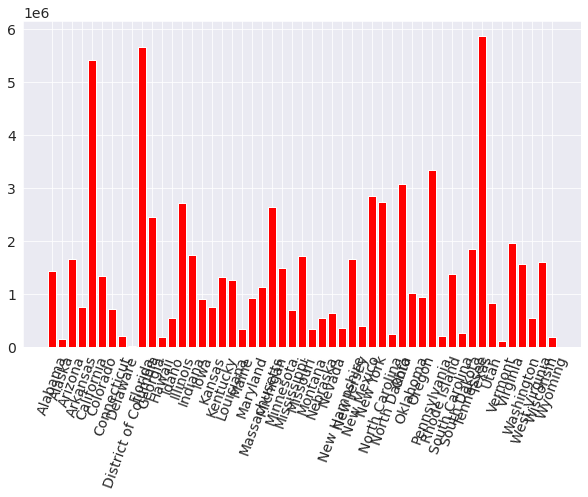

In [8]:
plt.xticks(rotation=70)
plt.bar(trump_df.state, trump_df.total_votes, color='red')
#plt.bar(biden_df.state, biden_df.total_votes, color='blue', bottom=trump_df.total_votes)
#plt.bar(jorgensen_df.state, jorgensen_df.total_votes, color='yellow', bottom=trump_df.total_votes)
plt.bar(writeins_df.state, writeins_df.total_votes, color='green', bottom=trump_df.total_votes);

NameError: ignored

In [45]:
president_county_candidate_df[president_county_candidate_df.candidate == ' Write-ins']

,state,county,candidate,party,total_votes,won
14,District of Columbia,District of Columbia,Write-ins,WRI,245,False
21,District of Columbia,Ward 2,Write-ins,WRI,314,False
28,District of Columbia,Ward 3,Write-ins,WRI,398,False
35,District of Columbia,Ward 4,Write-ins,WRI,248,False
42,District of Columbia,Ward 5,Write-ins,WRI,273,False
...,...,...,...,...,...,...
30770,Connecticut,Newtown,Write-ins,WRI,13,False
30774,Connecticut,Norfolk,Write-ins,WRI,5,False
30780,Connecticut,North Branford,Write-ins,WRI,1,False
30785,Connecticut,Bethel,Write-ins,WRI,3,False


In [48]:
president_county_candidate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31112 entries, 0 to 31111
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        31112 non-null  object
 1   county       31112 non-null  object
 2   candidate    31112 non-null  object
 3   party        31112 non-null  object
 4   total_votes  31112 non-null  int64 
 5   won          31112 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.2+ MB
